In [1]:
from ragraph.io.esl import from_esl
graph = from_esl(["./esl"])

import raesl.plot
figure = raesl.plot.mdm(
    graph,
    node_kinds=["component"],
)
figure.write_image("figures/dsm_components.svg")
figure.show()

from utils import set_edge_weights, annotate_variable_type
set_edge_weights(graph)
annotate_variable_type(graph)

In [4]:
import networkx as nx
from pyvis.network import Network
import os
import json

# ==========================================
# 1. SETUP & CONFIGURATION
# ==========================================
# Ensure we use the graph dictionary provided in your environment
try:
    graph_data = graph.as_dict()
except NameError:
    # Fallback for testing if 'graph' variable isn't defined in this context
    graph_data = {'nodes': {}, 'edges': {}} 

def create_site_structure(base_dir="site"):
    lib_dir = os.path.join(base_dir, "lib")
    if not os.path.exists(base_dir): os.makedirs(base_dir)
    if not os.path.exists(lib_dir): os.makedirs(lib_dir)

def visualize_complete_dashboard(data, output_dir="site", filename="index.html"):
    create_site_structure(output_dir)
    full_path = os.path.join(output_dir, filename)

    # ---------------------------------------------------------
    # 2. PARSE RAW DATA INTO NETWORKX
    # ---------------------------------------------------------
    RawG = nx.DiGraph()
    
    # Add Nodes
    for node_id, node_attrs in data['nodes'].items():
        RawG.add_node(node_id, **node_attrs)
        
    # Add Edges
    for edge_id, edge_attrs in data['edges'].items():
        attrs = edge_attrs.copy()
        src = attrs.pop('source')
        tgt = attrs.pop('target')
        attrs['original_id'] = edge_id 
        RawG.add_edge(src, tgt, **attrs)

    # ---------------------------------------------------------
    # 3. BUILD VISUALIZATION GRAPH (LOGIC LAYER)
    # ---------------------------------------------------------
    VisG = nx.DiGraph()
    variable_nodes = set()
    glue_nodes = [] # Models and Specs

    # Separate Variables from Logic Nodes
    for n, attrs in RawG.nodes(data=True):
        if attrs.get('kind') == 'variable':
            variable_nodes.add(n)
            VisG.add_node(n)
        else:
            glue_nodes.append(n)

    # --- Helper: Edge Attributes ---
    def get_width(weight, is_feedback=False):
        # Calculate thickness based on absolute weight
        base = 1 + (abs(float(weight)) * 2.0)
        return max(base, 3) if is_feedback else base

    def add_visual_edge(u, v, weight=1.0, edge_type='flow'):
        # Add edge to VisG if it doesn't exist or update if needed
        # We store 'weight_val' for dynamic width calculation later
        VisG.add_edge(u, v, 
                      color='#888888', 
                      width=get_width(weight, False), 
                      arrows='to', 
                      title=f"Weight: {weight}", 
                      weight_val=weight, 
                      edge_type=edge_type)

    # A. Process Direct Edges (Variable -> Variable)
    for u, v, attrs in RawG.edges(data=True):
        if u in variable_nodes and v in variable_nodes:
            # Check if this is a constraint or flow
            reason = attrs.get('annotations', {}).get('esl_info', {}).get('reason', {})
            e_type = 'constraint' if 'design_specifications' in reason else 'flow'
            
            # Get weight (default 1.0)
            w_dict = attrs.get('weights', {})
            w = float(w_dict.get('weight', w_dict.get('default', 1.0)))
            
            add_visual_edge(u, v, weight=w, edge_type=e_type)

    # B. Process Bridged Edges (Variable -> Model -> Variable)
    for glue in glue_nodes:
        # Skip purely passing through design specs for logic flow
        if RawG.nodes[glue].get('kind') == 'design_spec': continue
        
        # Parse Weights from Glue Node
        esl_info = RawG.nodes[glue].get('annotations', {}).get('esl_info', {})
        req_vars = esl_info.get('required_variables', [])
        weight_tags = esl_info.get('tagged_comments', {}).get('weight', [])
        
        # Map inputs to weights
        weight_map = {}
        if weight_tags:
            for var_name, w_val in zip(req_vars, weight_tags):
                try: weight_map[var_name] = float(w_val)
                except: weight_map[var_name] = 1.0

        # Connect Predecessors to Successors through this model
        preds = [p for p in RawG.predecessors(glue) if p in variable_nodes]
        succs = [s for s in RawG.successors(glue) if s in variable_nodes]
        
        for p in preds:
            w = weight_map.get(p, 1.0) 
            for s in succs:
                if not VisG.has_edge(p, s):
                    add_visual_edge(p, s, weight=w, edge_type='flow')

    # ---------------------------------------------------------
    # 4. DETECT & STYLE FEEDBACK LOOPS
    # ---------------------------------------------------------
    feedback_edges = set()
    try:
        cycles = list(nx.simple_cycles(VisG))
        for cycle in cycles:
            # Filter: A cycle is only a "Feedback Loop" if it contains ONLY flow edges.
            # If it traverses a Constraint (design_spec), it's just a check, not infinite feedback.
            is_true_feedback = True
            cycle_edges = []
            
            for i in range(len(cycle)):
                u, v = cycle[i], cycle[(i + 1) % len(cycle)]
                cycle_edges.append((u, v))
                if VisG.edges[u, v].get('edge_type') == 'constraint':
                    is_true_feedback = False
                    break
            
            if is_true_feedback:
                for u, v in cycle_edges:
                    feedback_edges.add((u, v))
        
        # Apply Purple Styling
        for u, v in feedback_edges:
            if VisG.has_edge(u, v):
                w = VisG.edges[u, v].get('weight_val', 1.0)
                VisG.edges[u, v]['color'] = '#FF00FF'
                VisG.edges[u, v]['width'] = get_width(w, is_feedback=True)
                
    except Exception as e:
        print(f"Cycle detection warning: {e}")

    # ---------------------------------------------------------
    # 5. PREPARE METADATA & COLORS
    # ---------------------------------------------------------
    # Classification
    inputs = set()
    outputs = set()
    intermediates = set()

    for n in VisG.nodes():
        if VisG.in_degree(n) == 0: inputs.add(n)
        elif VisG.out_degree(n) == 0: outputs.add(n)
        else: intermediates.add(n)

    # Refine Intermediates: If it only comes from other intermediates, distinct class.
    inter_outputs = set()
    for n in list(intermediates):
        predecessors = list(VisG.predecessors(n))
        # If NO predecessor is a root input, it is an intermediate sub-loop/output
        if not any(p in inputs for p in predecessors):
            inter_outputs.add(n)
            intermediates.remove(n)

    # Color Palettes
    flow_map = {
        'Input': "#3366FF", 
        'Output': "#33CC33", 
        'Intermediate': "#FFCC00", 
        'Intermediate Output': "#FF0000", 
        'Isolated': "#AAAAAA"
    }

    distinct_colors = [
        "#FF5733", "#33FF57", "#3357FF", "#FF33F6", "#33FFF6", "#F6FF33", 
        "#FF8C33", "#8C33FF", "#FF338C", "#33FF8C", "#581845", "#900C3F", 
        "#C70039", "#FFC300", "#DAF7A6", "#5DADE2", "#48C9B0", "#F4D03F",
        "#EB984E", "#AF7AC5", "#EC7063", "#58D68D", "#5D6D7E", "#DC7633",
        "#A569BD", "#45B39D", "#F5B041", "#CD6155", "#CACFD2", "#1F618D"
    ]
    
    # Dynamic Type Discovery
    all_types = sorted(list(set(RawG.nodes[n].get('annotations', {}).get('esl_info', {}).get('type_ref', 'Unknown') for n in variable_nodes)))
    type_map = {t: distinct_colors[i % len(distinct_colors)] for i, t in enumerate(all_types)}

    color_legends = { 'flow': flow_map, 'type': type_map }

    # ---------------------------------------------------------
    # 6. APPLY NODE ATTRIBUTES
    # ---------------------------------------------------------
    def get_node_type_shape(node_id):
        tags = RawG.nodes[node_id].get('annotations', {}).get('esl_info', {}).get('tagged_comments', {})
        if 'type' in tags and tags['type']:
            t = str(tags['type'][0]).lower()
            if '2d' in t: return '2d'
            if '3d' in t: return '3d'
        return 'both'

    for n in VisG.nodes():
        parts = n.split('.')
        parent_comp = ".".join(parts[:-1]) if len(parts) > 1 else "Root"
        type_ref = RawG.nodes[n].get('annotations', {}).get('esl_info', {}).get('type_ref', 'Unknown')
        
        flow_g = 'Isolated'
        if n in inputs: flow_g = 'Input'
        elif n in outputs: flow_g = 'Output'
        elif n in inter_outputs: flow_g = 'Intermediate Output'
        elif n in intermediates: flow_g = 'Intermediate'

        nt = get_node_type_shape(n)
        
        # Shape Logic
        shape = 'dot'
        size = 20
        if flow_g == 'Input':
            size = 30
            if nt == '2d': shape = 'diamond'
            elif nt == '3d': shape = 'triangle'
        elif flow_g == 'Output': size = 30

        # Hover Title (Plain Text)
        title = parts[-1]

        VisG.nodes[n].update({
            'label': parts[-1],
            'title': title,
            'shape': shape, 'size': size, 
            'color': flow_map[flow_g],
            'borderWidth': 2, 
            'font': {'color': 'white', 'strokeWidth': 4, 'strokeColor': 'black'},
            # JS Attributes
            'group_flow': flow_g, 
            'group_type': type_ref,
            'parent_comp': parent_comp,
            'node_type': nt,
            'is_root_input': n in inputs 
        })

    # ---------------------------------------------------------
    # 7. GENERATE HTML
    # ---------------------------------------------------------
    net = Network(height="90vh", width="100%", bgcolor="#222222", font_color="white", select_menu=False, filter_menu=False)
    net.from_nx(VisG)
    
    net.set_options("""
    var options = {
      "edges": { "arrows": { "to": { "enabled": true, "scaleFactor": 0.5 } }, "smooth": { "type": "continuous" } },
      "physics": {
        "forceAtlas2Based": { "gravitationalConstant": -80, "centralGravity": 0.005, "springLength": 80, "springConstant": 0.08, "damping": 0.4, "avoidOverlap": 0.8 },
        "maxVelocity": 40, "minVelocity": 0.1, "solver": "forceAtlas2Based"
      },
      "interaction": { "hover": true, "multiselect": true, "navigationButtons": true }
    }
    """)

    net.save_graph(full_path)
    
    # UI Data Injection
    node_options = "".join([f'<option value="{n}">{d["label"]}</option>' for n, d in sorted(VisG.nodes(data=True), key=lambda x: x[1]['label'])])
    type_options_html = "".join([f'<option value="{t}">{t}</option>' for t in sorted(all_types)])
    
    inject_ui(full_path, node_options, type_options_html, json.dumps(color_legends))
    print(f"Visualization saved to: {full_path}")

def inject_ui(filepath, node_options, type_options, json_legends):
    head_code = """
    <link href="https://cdn.jsdelivr.net/npm/tom-select@2.2.2/dist/css/tom-select.css" rel="stylesheet">
    <script src="https://cdn.jsdelivr.net/npm/tom-select@2.2.2/dist/js/tom-select.complete.min.js"></script>
    <style>
        body { margin: 0; padding: 0; overflow: hidden; font-family: 'Segoe UI', sans-serif; }
        
        /* Dark Theme Inputs */
        .ts-control { background: #333 !important; color: white !important; border: 1px solid #555 !important; border-radius: 4px; }
        .ts-control input { color: white !important; }
        .ts-dropdown { background: #333 !important; border: 1px solid #555 !important; }
        .ts-dropdown .option { color: white !important; }
        .ts-dropdown .active { background-color: #555 !important; color: white !important; }
        .ts-wrapper.multi .ts-control > div { background: #444 !important; color: white !important; border: 1px solid #666; }

        .card {
            background: rgba(50,50,50,0.95); color: white; 
            padding: 15px; border-radius: 8px; border: 1px solid #555; 
            box-shadow: 0 4px 8px rgba(0,0,0,0.4); font-size: 0.9em;
        }
        h4 { margin: 0 0 10px 0; border-bottom: 1px solid #555; padding-bottom: 8px; font-size: 1em; text-transform: uppercase; }

        .btn { width:100%; margin-top:5px; padding: 6px; background: #555; color: white; border: none; border-radius: 4px; cursor: pointer; font-weight: bold; }
        .btn:hover { background: #666; }
        .btn-active { background: #3366FF !important; }

        .bottom-card {
            position: absolute; bottom: 80px; left: 50%; transform: translateX(-50%);
            z-index: 999; background: rgba(50,50,50,0.95); width: 600px;
            padding: 10px; border-radius: 8px; border: 1px solid #555; display: flex; gap: 10px; align_items: center;
        }

        #path-modal {
            display: none; position: fixed; top: 0; left: 0; width: 100%; height: 100%;
            background: rgba(0,0,0,0.7); z-index: 2000;
        }
        .modal-content {
            position: absolute; top: 50%; left: 50%; transform: translate(-50%, -50%);
            background: #222; padding: 20px; border-radius: 8px; width: 600px; max-height: 80vh;
            border: 1px solid #555; display: flex; flex-direction: column; color: white;
        }
        .path-list { overflow-y: auto; flex-grow: 1; margin-top: 10px; border-top: 1px solid #444; }
        .path-item { padding: 8px; border-bottom: 1px solid #333; color: #ddd; font-size: 0.9em; cursor: pointer; }
        .path-item:hover { background: #333; color: #fff; }
        .close-btn { position: absolute; top: 10px; right: 15px; cursor: pointer; font-size: 1.2em; color: #aaa; }

        #legend {
            position: absolute; bottom: 15px; left: 50%; transform: translateX(-50%);
            z-index: 1; /* Pushed back */
            background: rgba(50,50,50,0.95);
            padding: 10px 20px; border-radius: 50px; border: 1px solid #555;
            display: flex; gap: 15px; align_items: center; box-shadow: 0 4px 8px rgba(0,0,0,0.4);
            flex-wrap: wrap; justify-content: center; max-width: 80%;
            color: white;
        }
        .legend-item { display: flex; align_items: center; gap: 6px; white-space: nowrap; }
        .shape { display: inline-block; }
        .circle { width: 12px; height: 12px; border-radius: 50%; }
        .diamond { width: 10px; height: 10px; transform: rotate(45deg); border: 2px solid white; }
        .triangle { width: 0; height: 0; border-left: 6px solid transparent; border-right: 6px solid transparent; border-top: 10px solid white; }
        
        .prop-row { display: flex; justify-content: space-between; margin-bottom: 4px; border-bottom: 1px solid #444; padding-bottom: 2px; }
        .prop-key { color: #aaa; }
        .prop-val { font-weight: bold; text-align: right; }
        
        .stat-grid { display: grid; grid-template-columns: 1fr 1fr 1fr; gap: 5px; margin-top: 10px; text-align: center; }
        .stat-box { background: #333; padding: 5px; border-radius: 4px; }
        .stat-label { font-size: 0.75em; color: #aaa; display: block; }
        .stat-num { font-size: 1.1em; font-weight: bold; color: #fff; }
        
        .input-list { max-height: 120px; overflow-y: auto; margin-top: 10px; border-top: 1px solid #444; padding-top: 5px; }
        .input-item { font-size: 0.85em; padding: 3px 0; color: #ddd; cursor: pointer; border-bottom: 1px solid #444; }
        .input-item:hover { color: #3366FF; background: #444; padding-left: 5px; }
    </style>
    """
    
    body_ui = f"""
    <div style="position: absolute; top: 15px; left: 50%; transform: translateX(-50%); z-index: 1000; width: 350px;">
        <select id="node-search" placeholder="Search variables..."><option value="">Search...</option>{node_options}</select>
    </div>

    <div class="card" style="position: absolute; top: 15px; left: 15px; z-index: 999; width: 260px;">
        <h4>Display Options</h4>
        <label style="color: #ccc;">Color View:</label>
        <select id="viewMode" onchange="updateView()" style="width: 100%; margin: 5px 0 15px 0; background: #333; color: white; border: 1px solid #555; padding: 4px;">
            <option value="flow">Flow Status</option>
            <option value="type">Variable Type</option>
        </select>
        
        <button id="freezeBtn" class="btn" onclick="togglePhysics()">❄ Freeze Graph</button>
        
        <h4 style="margin-top: 20px;">Filters</h4>
        <label style="color: #ccc; font-size:0.9em;">Group:</label>
        <select id="groupFilter" multiple placeholder="Select Groups..." style="width: 100%; margin-bottom: 10px;">
            <option value="Input">Inputs</option>
            <option value="Intermediate">Intermediate</option>
            <option value="Intermediate Output">Intermediate Output</option>
            <option value="Output">Outputs</option>
        </select>
        
        <label style="color: #ccc; font-size:0.9em;">Variable Type:</label>
        <select id="typeFilter" multiple placeholder="Select Types..." style="width: 100%;">
            {type_options}
        </select>
        
        <button class="btn" onclick="resetAll()" style="margin-top:15px;">⟳ Reset View</button>
    </div>

    <div id="selection-card" class="card" style="position: absolute; top: 15px; right: 15px; z-index: 999; width: 300px; display: none;">
        <h4>Selection Analysis</h4>
        <div id="sel-name" style="font-weight: bold; margin-bottom: 10px; color: #4DA3FF; word-break: break-all; font-size: 1.1em;"></div>
        
        <div class="prop-row"><span class="prop-key">Type:</span> <span id="sel-type" class="prop-val">-</span></div>
        
        <div style="margin-top: 10px; font-size: 0.85em; text-transform: uppercase; color: #888;">Contributing Root Inputs</div>
        <div class="stat-grid">
            <div class="stat-box"><span class="stat-label">3D Input</span><span id="count-3d" class="stat-num">0</span></div>
            <div class="stat-box"><span class="stat-label">2D Input</span><span id="count-2d" class="stat-num">0</span></div>
            <div class="stat-box"><span class="stat-label">Both</span><span id="count-both" class="stat-num">0</span></div>
        </div>

        <div style="margin-top: 10px; font-size: 0.85em; text-transform: uppercase; color: #888;">Direct Parents</div>
        <div id="input-list" class="input-list"></div>
    </div>
    
    <div class="bottom-card">
        <div style="flex:1;">
            <select id="path-start" placeholder="From Node..."><option value="">From...</option>{node_options}</select>
        </div>
        <div style="flex:1;">
            <select id="path-end" placeholder="To Node..."><option value="">To...</option>{node_options}</select>
        </div>
        <button onclick="calculatePaths()" style="padding: 8px 15px; background: #3366FF; border: none; color: white; border-radius: 4px; cursor: pointer; font-weight: bold;">Find Paths</button>
    </div>

    <div id="path-modal">
        <div class="modal-content">
            <span class="close-btn" onclick="closeModal()">×</span>
            <h3 style="margin-top: 0;">Paths Found</h3>
            <div id="path-results" class="path-list"></div>
        </div>
    </div>

    <div id="legend"></div>
    """

    js_logic = f"""
    <script type="text/javascript">
        var colorMaps = {json_legends};
        var currentView = 'flow';
        var isFrozen = false;
        var allNodeIds = nodes.getIds();
        
        // --- Init TomSelects ---
        var searchSelect = new TomSelect("#node-search",{{ create: false, sortField: {{field: "text", direction: "asc"}}, onChange: function(val) {{ if(val) selectNode(val); }} }});
        var groupFilterSelect = new TomSelect("#groupFilter", {{ plugins: ['remove_button'], onChange: function() {{ applyFilters(); }} }});
        var typeFilterSelect = new TomSelect("#typeFilter", {{ plugins: ['remove_button'], onChange: function() {{ applyFilters(); }} }});
        var pathStartSelect = new TomSelect("#path-start", {{ create: false, sortField: {{field: "text", direction: "asc"}} }});
        var pathEndSelect = new TomSelect("#path-end", {{ create: false, sortField: {{field: "text", direction: "asc"}} }});

        function togglePhysics() {{
            isFrozen = !isFrozen;
            network.setOptions({{ physics: {{ enabled: !isFrozen }} }});
            var btn = document.getElementById('freezeBtn');
            if(isFrozen) {{ btn.innerText="▶ Unfreeze Graph"; btn.classList.add('btn-active'); }}
            else {{ btn.innerText="❄ Freeze Graph"; btn.classList.remove('btn-active'); }}
        }}

        function updateView() {{
            currentView = document.getElementById('viewMode').value;
            var map = colorMaps[currentView];
            var updates = [];
            allNodeIds.forEach(id => {{
                var n = nodes.get(id);
                var k = (currentView==='flow') ? n.group_flow : n.group_type;
                updates.push({{id: id, color: map[k] || '#888'}});
            }});
            nodes.update(updates);
            renderLegend(map);
        }}

        function renderLegend(map) {{
            var c = document.getElementById('legend');
            var h = '';
            if(currentView === 'flow') {{
                h += '<div class="legend-item"><div class="shape diamond" style="background:#3366FF;"></div> 2D</div>';
                h += '<div class="legend-item"><div class="shape triangle" style="border-top-color:#3366FF;"></div> 3D</div>';
                h += '<div style="width:1px; height:20px; background:#555; margin:0 10px;"></div>';
            }}
            for(var k in map) {{
                h += '<div class="legend-item"><div class="shape circle" style="background:'+map[k]+';"></div> '+k+'</div>';
            }}
            h += '<div style="width:1px; height:20px; background:#555; margin:0 10px;"></div>';
            h += '<div class="legend-item"><div style="width:20px; height:3px; background:#FF00FF;"></div> Loop</div>';
            c.innerHTML = h;
        }}

        function selectNode(id) {{
            var stats = highlightUpstream(id);
            var n = nodes.get(id);
            
            document.getElementById('sel-name').innerText = n.label;
            document.getElementById('sel-type').innerText = n.group_type;
            
            document.getElementById('count-3d').innerText = stats.c3d;
            document.getElementById('count-2d').innerText = stats.c2d;
            document.getElementById('count-both').innerText = stats.cboth;
            
            var list = document.getElementById('input-list');
            list.innerHTML = '';
            var parents = network.getConnectedNodes(id, 'from');
            
            if(parents.length === 0) {{
                list.innerHTML = '<div style="padding:5px; color:#666;">No direct parents</div>';
            }} else {{
                parents.forEach(pid => {{
                    var pn = nodes.get(pid);
                    var div = document.createElement('div');
                    div.className = 'input-item';
                    div.innerText = '↳ ' + pn.label;
                    div.onclick = function() {{ selectNode(pid); searchSelect.setValue(pid, true); }};
                    list.appendChild(div);
                }});
            }}
            
            document.getElementById('selection-card').style.display = 'block';
            network.selectNodes([id]);
            network.focus(id, {{scale: 1.2, animation: true}});
        }}

        function applyFilters() {{
            var selGroups = groupFilterSelect.getValue(); 
            var selTypes = typeFilterSelect.getValue();   
            var upd = [];
            allNodeIds.forEach(id => {{
                var n = nodes.get(id);
                var show = true;
                if (selGroups.length > 0 && !selGroups.includes(n.group_flow)) show = false;
                if (selTypes.length > 0 && !selTypes.includes(n.group_type)) show = false;
                upd.push({{id: id, hidden: !show, opacity: 1}});
            }});
            nodes.update(upd);
        }}

        function resetAll() {{
            searchSelect.clear();
            document.getElementById('selection-card').style.display = 'none';
            groupFilterSelect.clear();
            typeFilterSelect.clear();
            pathStartSelect.clear();
            pathEndSelect.clear();
            updateView();
            
            var nUp = [], eUp = [];
            allNodeIds.forEach(id => nUp.push({{id: id, opacity: 1, hidden: false}}));
            for(var eid in allEdges) eUp.push({{id: eid, opacity: 1, hidden: false}});
            nodes.update(nUp);
            edges.update(eUp);
        }}

        function highlightUpstream(startId) {{
            var set = new Set();
            var stats = {{ c2d: 0, c3d: 0, cboth: 0 }};
            
            function trace(id) {{
                if(set.has(id)) return;
                set.add(id);
                var n = nodes.get(id);
                if(n.is_root_input) {{
                    if(n.node_type === '2d') stats.c2d++;
                    else if(n.node_type === '3d') stats.c3d++;
                    else stats.cboth++;
                }}
                var parents = network.getConnectedNodes(id, 'from');
                parents.forEach(pid => trace(pid));
            }}
            trace(startId);
            
            var nUp = [], eUp = [];
            var map = colorMaps[currentView];
            
            allNodeIds.forEach(id => {{
                var n = nodes.get(id);
                var col = map[currentView==='flow' ? n.group_flow : n.group_type] || '#888';
                
                if(set.has(id)) {{
                    nUp.push({{id: id, color: col, opacity: 1, hidden: false}});
                }} else {{
                    nUp.push({{id: id, color: '#444', opacity: 0.1, hidden: false}});
                }}
            }});
            
            var edgeIds = edges.getIds();
            edgeIds.forEach(eid => {{
                var e = edges.get(eid);
                if(set.has(e.from) && set.has(e.to)) {{
                    eUp.push({{id: eid, opacity: 1, hidden: false}});
                }} else {{
                    eUp.push({{id: eid, opacity: 0.05, hidden: false}});
                }}
            }});
            nodes.update(nUp);
            edges.update(eUp);
            return stats;
        }}

        // --- PATH FINDING LOGIC ---
        function calculatePaths() {{
            var start = document.getElementById('path-start').value;
            var end = document.getElementById('path-end').value;
            if(!start || !end) {{ alert("Please select both a Start and End node."); return; }}
            
            var paths = findAllPaths(start, end);
            var container = document.getElementById('path-results');
            container.innerHTML = '';
            
            if(paths.length === 0) {{
                container.innerHTML = '<div style="padding:10px; color:#aaa;">No paths found between these nodes.</div>';
            }} else {{
                paths.forEach((path, idx) => {{
                    var div = document.createElement('div');
                    div.className = 'path-item';
                    
                    var names = path.map(id => nodes.get(id).label);
                    div.innerText = (idx+1) + ". " + names.join(" → ");
                    
                    div.onmouseenter = function() {{ highlightPath(path); }};
                    div.onmouseleave = function() {{ selectNode(start); }}; 
                    
                    container.appendChild(div);
                }});
            }}
            document.getElementById('path-modal').style.display = 'block';
        }}

        function findAllPaths(start, end) {{
            var results = [];
            var stack = [{{ curr: start, path: [start], visited: new Set([start]) }}];
            
            while(stack.length > 0) {{
                var item = stack.pop();
                var u = item.curr;
                var path = item.path;
                var visited = item.visited;

                if (u === end) {{
                    results.push(path);
                    if(results.length >= 50) break; 
                    continue;
                }}

                var neighbors = network.getConnectedNodes(u, 'to');
                for(var i=0; i<neighbors.length; i++) {{
                    var v = neighbors[i];
                    if(!visited.has(v)) {{
                        var newVisited = new Set(visited);
                        newVisited.add(v);
                        stack.push({{ curr: v, path: [...path, v], visited: newVisited }});
                    }}
                }}
            }}
            return results;
        }}
        
        function highlightPath(pathNodeIds) {{
            var pSet = new Set(pathNodeIds);
            var nUp = [], eUp = [];
            
            allNodeIds.forEach(id => {{
                if(pSet.has(id)) nUp.push({{id: id, opacity: 1, hidden: false}});
                else nUp.push({{id: id, opacity: 0.1, hidden: false}});
            }});
            
            var edgeIds = edges.getIds();
            edgeIds.forEach(eid => {{
                var e = edges.get(eid);
                var isPathEdge = false;
                for(var i=0; i<pathNodeIds.length-1; i++) {{
                    if(pathNodeIds[i] === e.from && pathNodeIds[i+1] === e.to) {{
                        isPathEdge = true; break;
                    }}
                }}
                if(isPathEdge) eUp.push({{id: eid, opacity: 1, hidden: false, width: 4}});
                else eUp.push({{id: eid, opacity: 0.05, hidden: false, width: 1}});
            }});
            nodes.update(nUp);
            edges.update(eUp);
        }}

        function closeModal() {{
            document.getElementById('path-modal').style.display = 'none';
            resetAll();
        }}

        network.on("click", function(p) {{
            if(p.nodes.length) {{ 
                selectNode(p.nodes[0]); 
                searchSelect.setValue(p.nodes[0], true); 
            }}
            else resetAll();
        }});

        updateView();
    </script>
    """

    with open(filepath, "r") as f:
        content = f.read()

    if "</head>" in content:
        content = content.replace("</head>", head_code + "\n</head>")
    if "<body>" in content:
        content = content.replace("<body>", "<body>\n" + body_ui)
    if "</body>" in content:
        content = content.replace("</body>", js_logic + "\n</body>")
        
    with open(filepath, "w") as f:
        f.write(content)

# Run
visualize_complete_dashboard(graph_data)

Visualization saved to: site/index.html


In [88]:
import ragraph.plot

figure = raesl.plot.mdm(
    graph,
    node_kinds=["component", "variable"],
    depth=2,
    style=raesl.plot.Style(
        ragraph=ragraph.plot.Style(
            piemap=dict(
                display="weights",
                mode= "relative",
                fields=["weight"]
            ),
        )
    )
)

figure.write_image("figures/mdm_weights.svg")
figure.show()

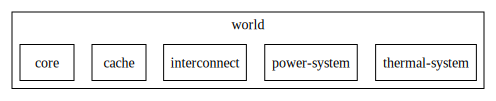

In [89]:
digraph = raesl.plot.functional_dependency_diagram(
    graph,
    root=graph["world"],
    levels=2,
)
digraph

In [90]:
figure = raesl.plot.mdm(
    graph,
    # node_kinds=["component", "variable", "function_spec", "design_spec", "relation_spec"],
    # edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=2,
)
figure.write_image("figures/mdm.svg")
# figure.show()

In [91]:
# from raesl.plot.view_funcs import multi_domain
# from ragraph.analysis import cluster

# nodes, edges = multi_domain(
#     graph,
#     depth=4
# )

# relations = [n for n in nodes if n.kind == "relation_spec"]
# variables = [n for n in nodes if n.kind == "variable"]
# components = [n for n in nodes if n.kind == "component"]

# # Cluster components
# cluster.tarjans_scc(
#     graph=graph,
#     leafs = relations+variables,
# )

# # Reloaded MDM based on clustered graph.
# figure = raesl.plot.mdm(
#     graph,
#     # node_kinds=["component", "variable", "function_spec", "design_spec", "relation_spec"],
#     # edge_kinds=["functional_dependency", "mapping_dependency"],
#     depth=2,
# )
# figure.write_image("figures/mdm_clustered.svg")
# # figure.show()

In [92]:
from ragraph.analysis import sequence
import ragraph.plot

from raesl.plot.view_funcs import multi_domain

nodes, edges = multi_domain(
    graph,
    depth=4
)

relations = [n for n in nodes if n.kind == "relation_spec"]
variables = [n for n in nodes if n.kind == "variable"]
components = [n for n in nodes if n.kind == "component"]


_, _, sequenced_functions = sequence.utils.branchsort(algo=sequence.scc_tearing, graph=graph, algo_args=dict(inf=1, dep=1, mu=3), inplace=True, nodes=relations+variables, edge_weights=graph.weights)

# Reload figure based on sequence.
figure = ragraph.plot.mdm(
    leafs = components + sequenced_functions,
    edges = edges,
    node_kinds=["component", "variable", "relation_spec"],
    style= ragraph.plot.Style(
        piemap=dict(
            display="weights",
            mode= "relative",
            fields=["weight"]
        ),
    )
)

figure.write_image("figures/mdm_sequenced.svg")
figure.show()